# Analysis of CMAQ HR2DAY Output

**Author:** Michael Needham, US EPA Region 7 Air and Radiation Division

**Contact:** needham.michael@epa.gov

**Description:** Builds on the previous example (__[Example 1](./01_minimal_cmaq_plotting_example.ipynb)__) to demonstrate the following funcionality:
* Subset output data to generate a timeseries at a point using __[xarray.DataArray.sel](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html)__; for additional information, see __[Indexing and Selecting Data](https://docs.xarray.dev/en/latest/user-guide/indexing.html)__ from the xarray documentation.
    * Formatting of matplotlib axes for datetime applications based on __[matplotlib.dates](https://matplotlib.org/stable/api/dates_api.html)__ 
* Generate maps of daily maximum O3 on days in which the model predicts that MDA8O3 exceeds the NAAQS in St. Louis
    * Compare equivalent methods of identifying and selecting ozone exceedance days using __[pandas](https://pandas.pydata.org/docs/user_guide/indexing.html)__ and __[Xarray](https://docs.xarray.dev/en/latest/user-guide/indexing.html)__
    * Basic matplotlib colorbar customizations using __[matplotlib.colors.ListedColormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html)__; for additional information, see __[Creating Colormaps in Matplotlib](https://matplotlib.org/stable/users/explain/colors/colormap-manipulation.html)__ from the matplotlib documentation.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
import shapely

from pathlib import Path

ERROR 1: PROJ: proj_create_from_database: Open of /work/REGIONS/users/mneedham/.miniforge3/envs/cmaq_pyenv/share/proj failed


## 1. Data I/O

<div class="alert alert-block alert-info">
This tutorial uses a file <code>./tutorial_data/DDM_2022_36US3.011.HR2DAY.2022120-2022217.nc</code> which was generated in the <b><a href="./A1_concat_files.ipynb">concat files</a></b> auxiliary example. Note that the output file has already been formatted using <code>src.utils.cmaq.get_cmaq_metadata</code> as part of that auxiliary example.
</div>

In [3]:
from src.utils.cmaq import get_cmaq_projection

In [4]:
file = Path("./tutorial_data/DDM_2022_36US3.011.HR2DAY.2022120-2022217.nc")

dset = xr.open_dataset(file)
proj = get_cmaq_projection(dset)

dset

<xarray.Dataset> Size: 20MB
Dimensions:  (time: 97, VAR: 2, DATE-TIME: 2, y: 148, x: 172)
Coordinates:
  * x        (x) float64 1kB 0.0 3.6e+04 7.2e+04 ... 6.12e+06 6.156e+06
  * y        (y) float64 1kB 0.0 3.6e+04 7.2e+04 ... 5.256e+06 5.292e+06
  * time     (time) datetime64[ns] 776B 2022-04-30 2022-05-01 ... 2022-08-05
Dimensions without coordinates: VAR, DATE-TIME
Data variables:
    TFLAG    (time, VAR, DATE-TIME) int32 2kB ...
    O3       (time, y, x) float32 10MB ...
    PM25     (time, y, x) float32 10MB ...
Attributes: (12/33)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 247 2023-03-22 15:59:19Z coats ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2024156
    CTIME:          204606
    WDATE:          2024156
    ...             ...
    VGLVLS:         [1.     0.9975]
    GDNAM:          36US3           
    UPNAM:          hr2day          
    VAR-LIST:       O3              PM25            
    FILEDESC:       Parameters Relevant for PM Formation and Distribution    ...
    HISTORY:

In [5]:
print(f"Total size of the dataset: {dset.nbytes / 1e6} MB")

Total size of the dataset: 19.758744 MB


## 2. Generate a timeseries at a point

### 2.A Coordinate Transformation

In this example, we will generate a timeseries of MDA8O3 ozone near St. Louis (39N, 90.5W) from the CMAQ output. 

<div class="alert alert-block alert-warning">
<b>Note on coordinate systems:</b> The x and y coordinates of the dataset are in the native lambert conformal coordinate system, while the coordinates for St. Louis are in basic latitude and longitude. To accomplish the indexing, we will need to convert the desired latitude and longitude coordinates for St. Louis into the lambert conformal coordinate system. There are multiple python packages that implement this functionality (including <b><a href="https://pyproj4.github.io/pyproj/stable/api/transformer.html">pyproj.Transformer</a></b>), but the <b><a href="https://geopandas.org/en/stable/index.html">GeoPandas</a></b> implementation with <b><a href="https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html">geopandas.GeoDataFrame.to_crs</a></b> is the most straightfoward in my opinion.
</div>

In [6]:
# Specify the coordinates in lat/lon, then transform to the desired lambert
# coordinate system using geopandas

lon = -90.5
lat = 39

# Specify the desired point in the original (lat/lon) coordinate system
pt_latlon = gpd.GeoDataFrame(
    geometry=[shapely.Point(lon, lat)],
    crs=ccrs.PlateCarree(),  # <- native crs is lat/lon
)

# Transform from the original crs to the lambert projection of the data
pt_lambert = pt_latlon.to_crs(proj)


print("Native Coordinates")
print("=" * 40)
print(pt_latlon)
print("\n")


print("Transformed Coordinates")
print("=" * 40)
print(pt_lambert)

Native Coordinates
                 geometry
0  POINT (-90.500 39.000)


Transformed Coordinates
                          geometry
0  POINT (3511520.308 2681596.008)


<GeoAxes: title={'center': 'Lambert Projection'}>

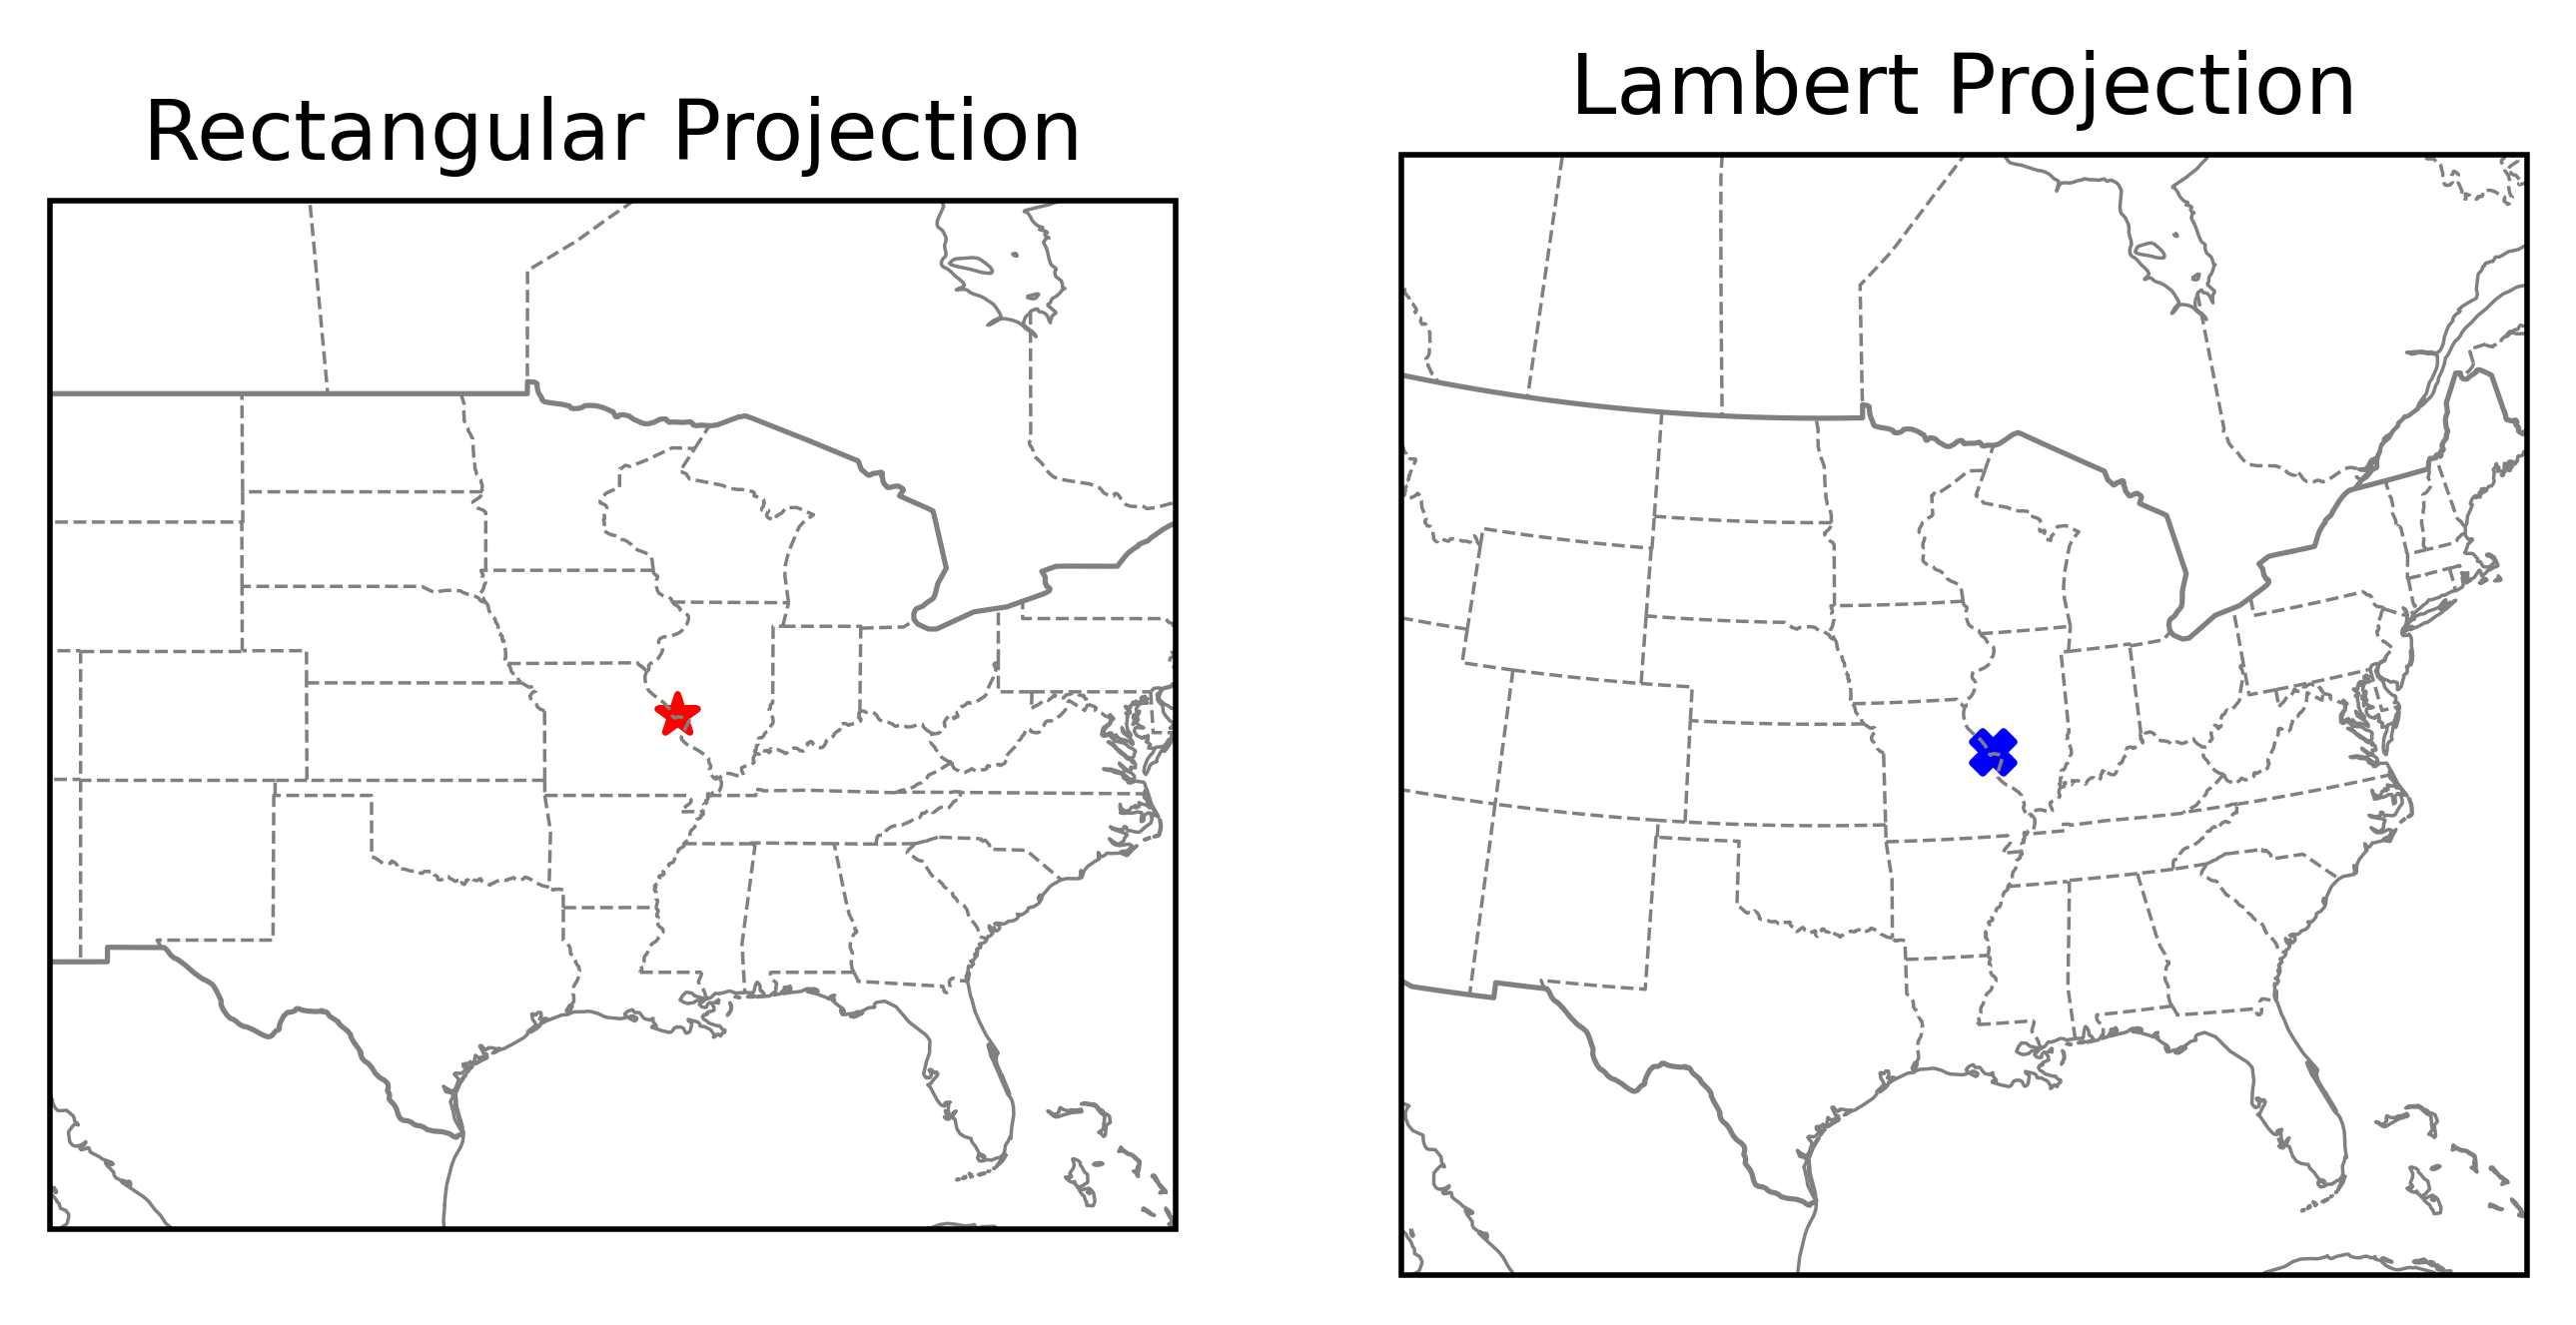

In [7]:
# Make a simple map using the desired (lambert) projection to ensure that the
# transformation worked as expected

states_provinces = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_1_states_provinces_lines",
    scale="50m",
)

fig = plt.figure(dpi=500)

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, projection=proj)

ax1.set_title("Rectangular Projection")
ax2.set_title("Lambert Projection")

for ax in [ax1, ax2]:

    # Add features for spatial orientation
    ax.add_feature(cfeature.BORDERS, ec="grey", fc="none", lw=0.75)
    ax.add_feature(states_provinces, ec="grey", fc="none", lw=0.5, ls="--")
    ax.coastlines(color="grey", lw=0.5)

    ax.set_extent([-110, -75, 23, 55], crs=ccrs.PlateCarree())

pt_latlon.plot(ax=ax1, color="r", marker="*")
pt_lambert.plot(ax=ax2, color="b", marker="X")

### 2.B Index the data

> Here, we use __[xarray.DataArray.sel](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html)__ to find the nearest neighbor, but another option would be to use  __[xarray.DataArray.interp](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.interp.html)__ to interpolate directly to the desired point. 

In [8]:
# Get the x and y coordinates of the transformation
x = pt_lambert.geometry.x.iloc[0]
y = pt_lambert.geometry.y.iloc[0]

print(f"{x=} | {y=}")

# Use x and y to find the nearest gridcell.
dset_stl = dset.sel(x=x, y=y, method="nearest")

# Note that the printout no longer has x and y "Dimensions," but just has a
# single value for x and y under "Coordinates"
dset_stl

x=3511520.3075875556 | y=2681596.0083958106


<xarray.Dataset> Size: 3kB
Dimensions:  (time: 97, VAR: 2, DATE-TIME: 2)
Coordinates:
    x        float64 8B 3.528e+06
    y        float64 8B 2.664e+06
  * time     (time) datetime64[ns] 776B 2022-04-30 2022-05-01 ... 2022-08-05
Dimensions without coordinates: VAR, DATE-TIME
Data variables:
    TFLAG    (time, VAR, DATE-TIME) int32 2kB ...
    O3       (time) float32 388B ...
    PM25     (time) float32 388B ...
Attributes: (12/33)
    IOAPI_VERSION:  ioapi-3.2: $Id: init3.F90 247 2023-03-22 15:59:19Z coats ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2024156
    CTIME:          204606
    WDATE:          2024156
    ...             ...
    VGLVLS:         [1.     0.9975]
    GDNAM:          36US3           
    UPNAM:          hr2day          
    VAR-LIST:       O3              PM25            
    FILEDESC:       Parameters Relevant for PM Formation and Distribution    ...
    HISTORY:

### 2.C Make Plots

#### Plot 1: Basic Timeseries

> Shows an example of a simple plot based mostly on default parameters

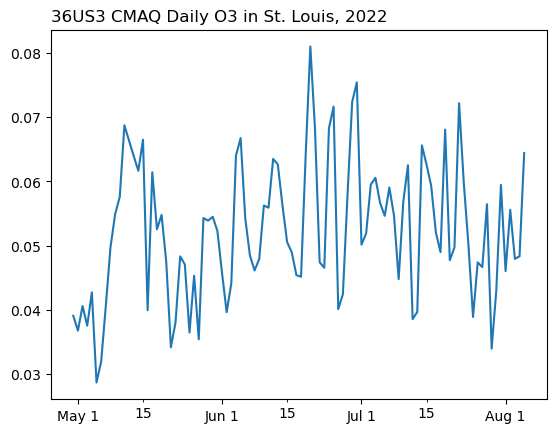

In [9]:
field = "O3"
format_dateaxis = True

fig, ax = plt.subplots()

ax.plot(dset_stl.time, dset_stl[field])

ax.set_title(f"36US3 CMAQ Daily {field} in St. Louis, 2022", loc="left")

if format_dateaxis:
    ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=1))
    ax.xaxis.set_minor_locator(mpl.dates.DayLocator(bymonthday=[15]))

    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %-d"))
    ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%-d"))

#### Plot 2: Timeseries with additional customizations

Primary Changes:
* Format the x axis to based on the __[matplotlib.dates](https://matplotlib.org/stable/api/dates_api.html)__ api
* Highlight exceedances of the MDA8O3 NAAQS of 0.070 ppm

In [10]:
# Select only points where MDA8O3 is strictly greater than 0.070
excd = dset_stl[field].isel(time=dset_stl[field] > 0.070)

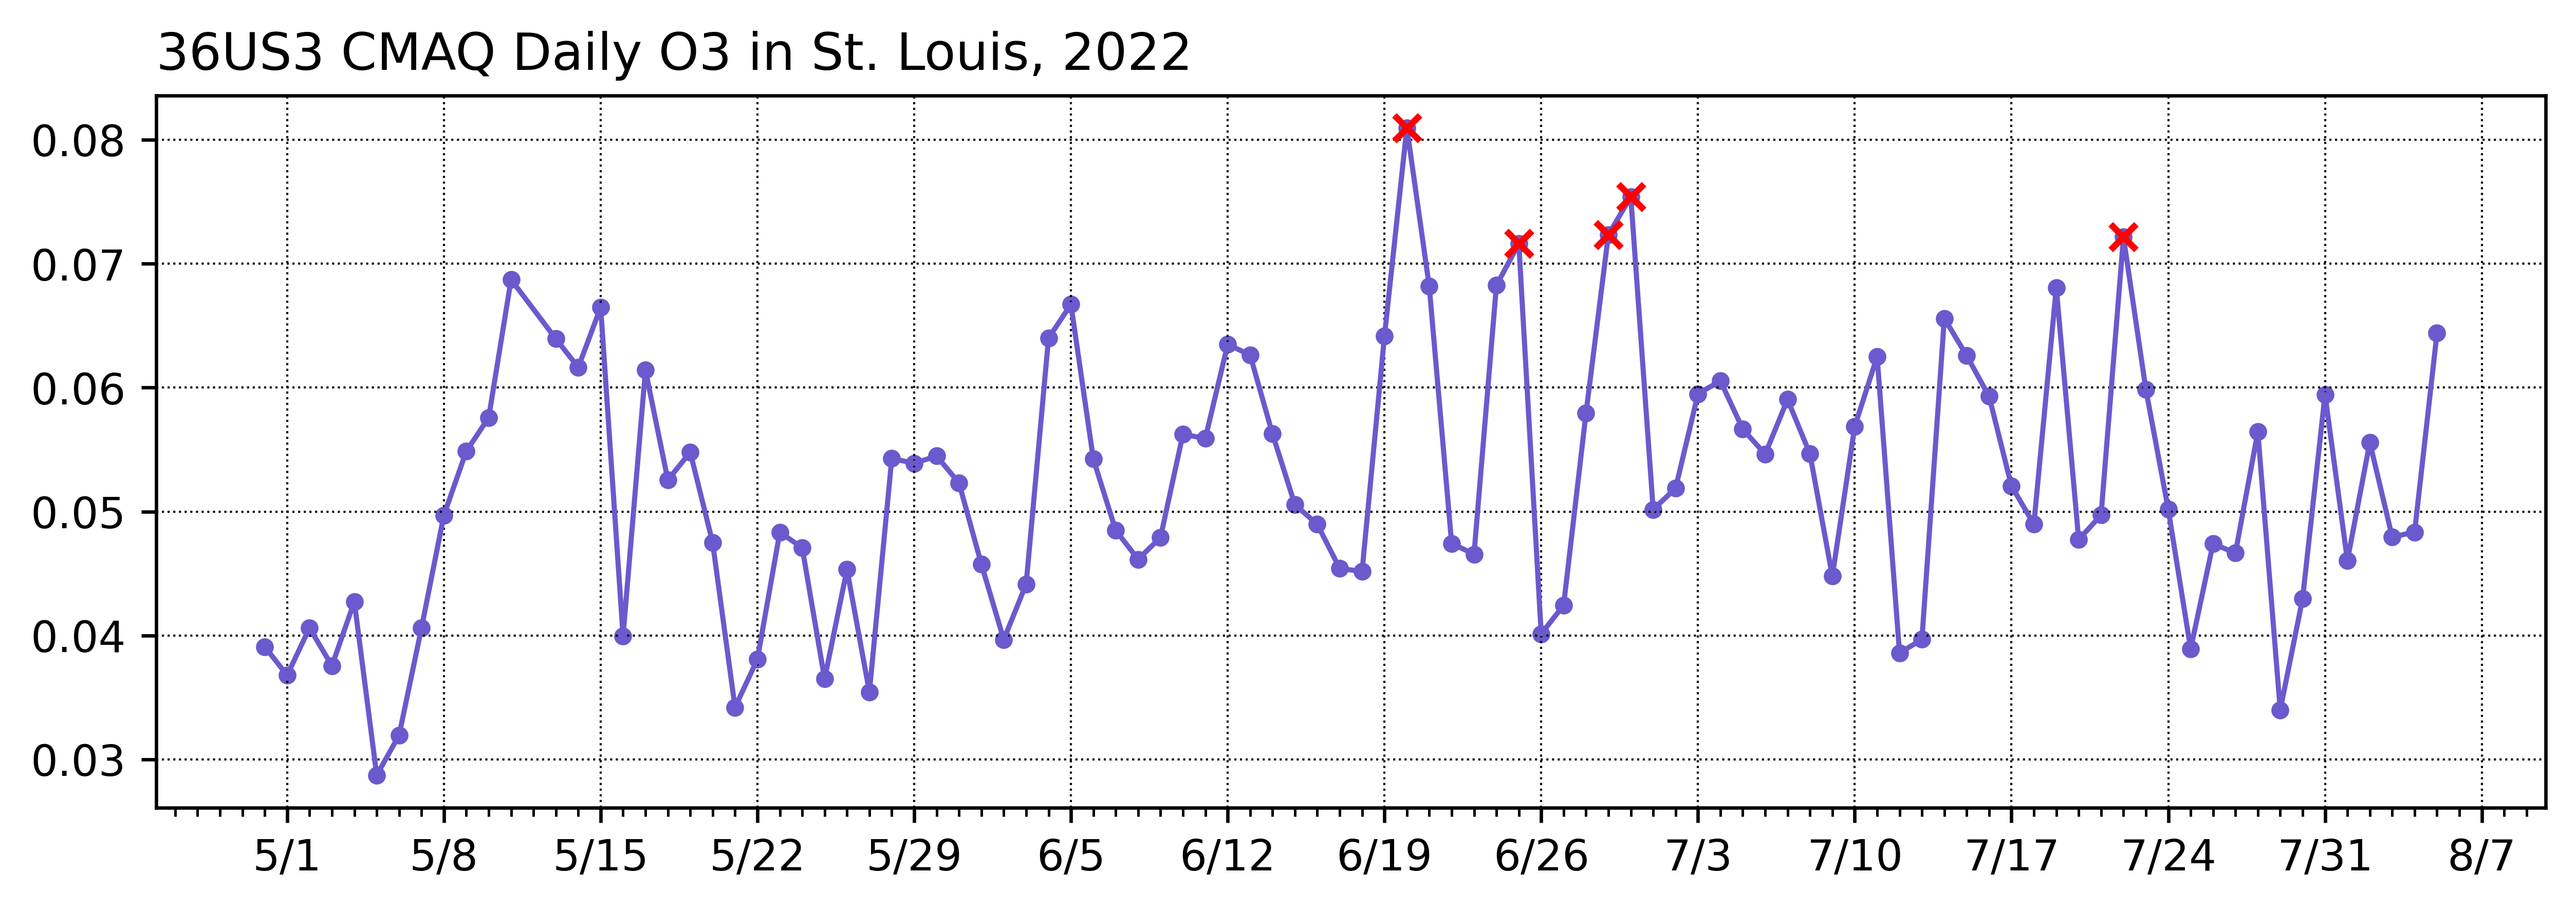

In [11]:
field = "O3"
format_dateaxis = True
color = "slateblue"

fig, ax = plt.subplots(figsize=(10, 3), dpi=600)

ax.plot(dset_stl.time, dset_stl[field], color=color, lw=1.2)  # <- this draws the line
ax.scatter(dset_stl.time, dset_stl[field], color=color, s=10)  # <- this draws the pts
ax.scatter(
    excd.time, excd, color="r", marker="x", zorder=10
)  # <- this highlights exceedances

ax.set_title(f"36US3 CMAQ Daily {field} in St. Louis, 2022", loc="left")

ax.grid(which="major", lw=0.5, color="k", ls=":")

if format_dateaxis:
    ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mpl.dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%-m/%-d"))

## 3. Plot Maps of Ozone Exceedance Days



### 3.A Make Plots


Here we will find the date within the dataset in which the greatest number of ozone exceedances are found.

This first image contains a lot of information, and it is clear that there are elevated ozone concentrations around the great lakes. However because of the continuous colormap, it is difficult to determine where the modeled ozone is in excess of the 0.070 ppb NAAQS for the daily maximum of 8-hour averaged concentrations.

In [12]:
# Find the date with the greatest number of exceedances across the domain to
# demonstrate the importance of thoughtfully choosing a colormap

excd_per_day = (dset["O3"] > 0.070).sum(dim=("y", "x")).to_pandas()
sample_date = excd_per_day.sort_values(ascending=False).index[0]

Text(0.0, 1.0, '36US3 Daily Maximum 8Hour Ozone June 21, 2022')

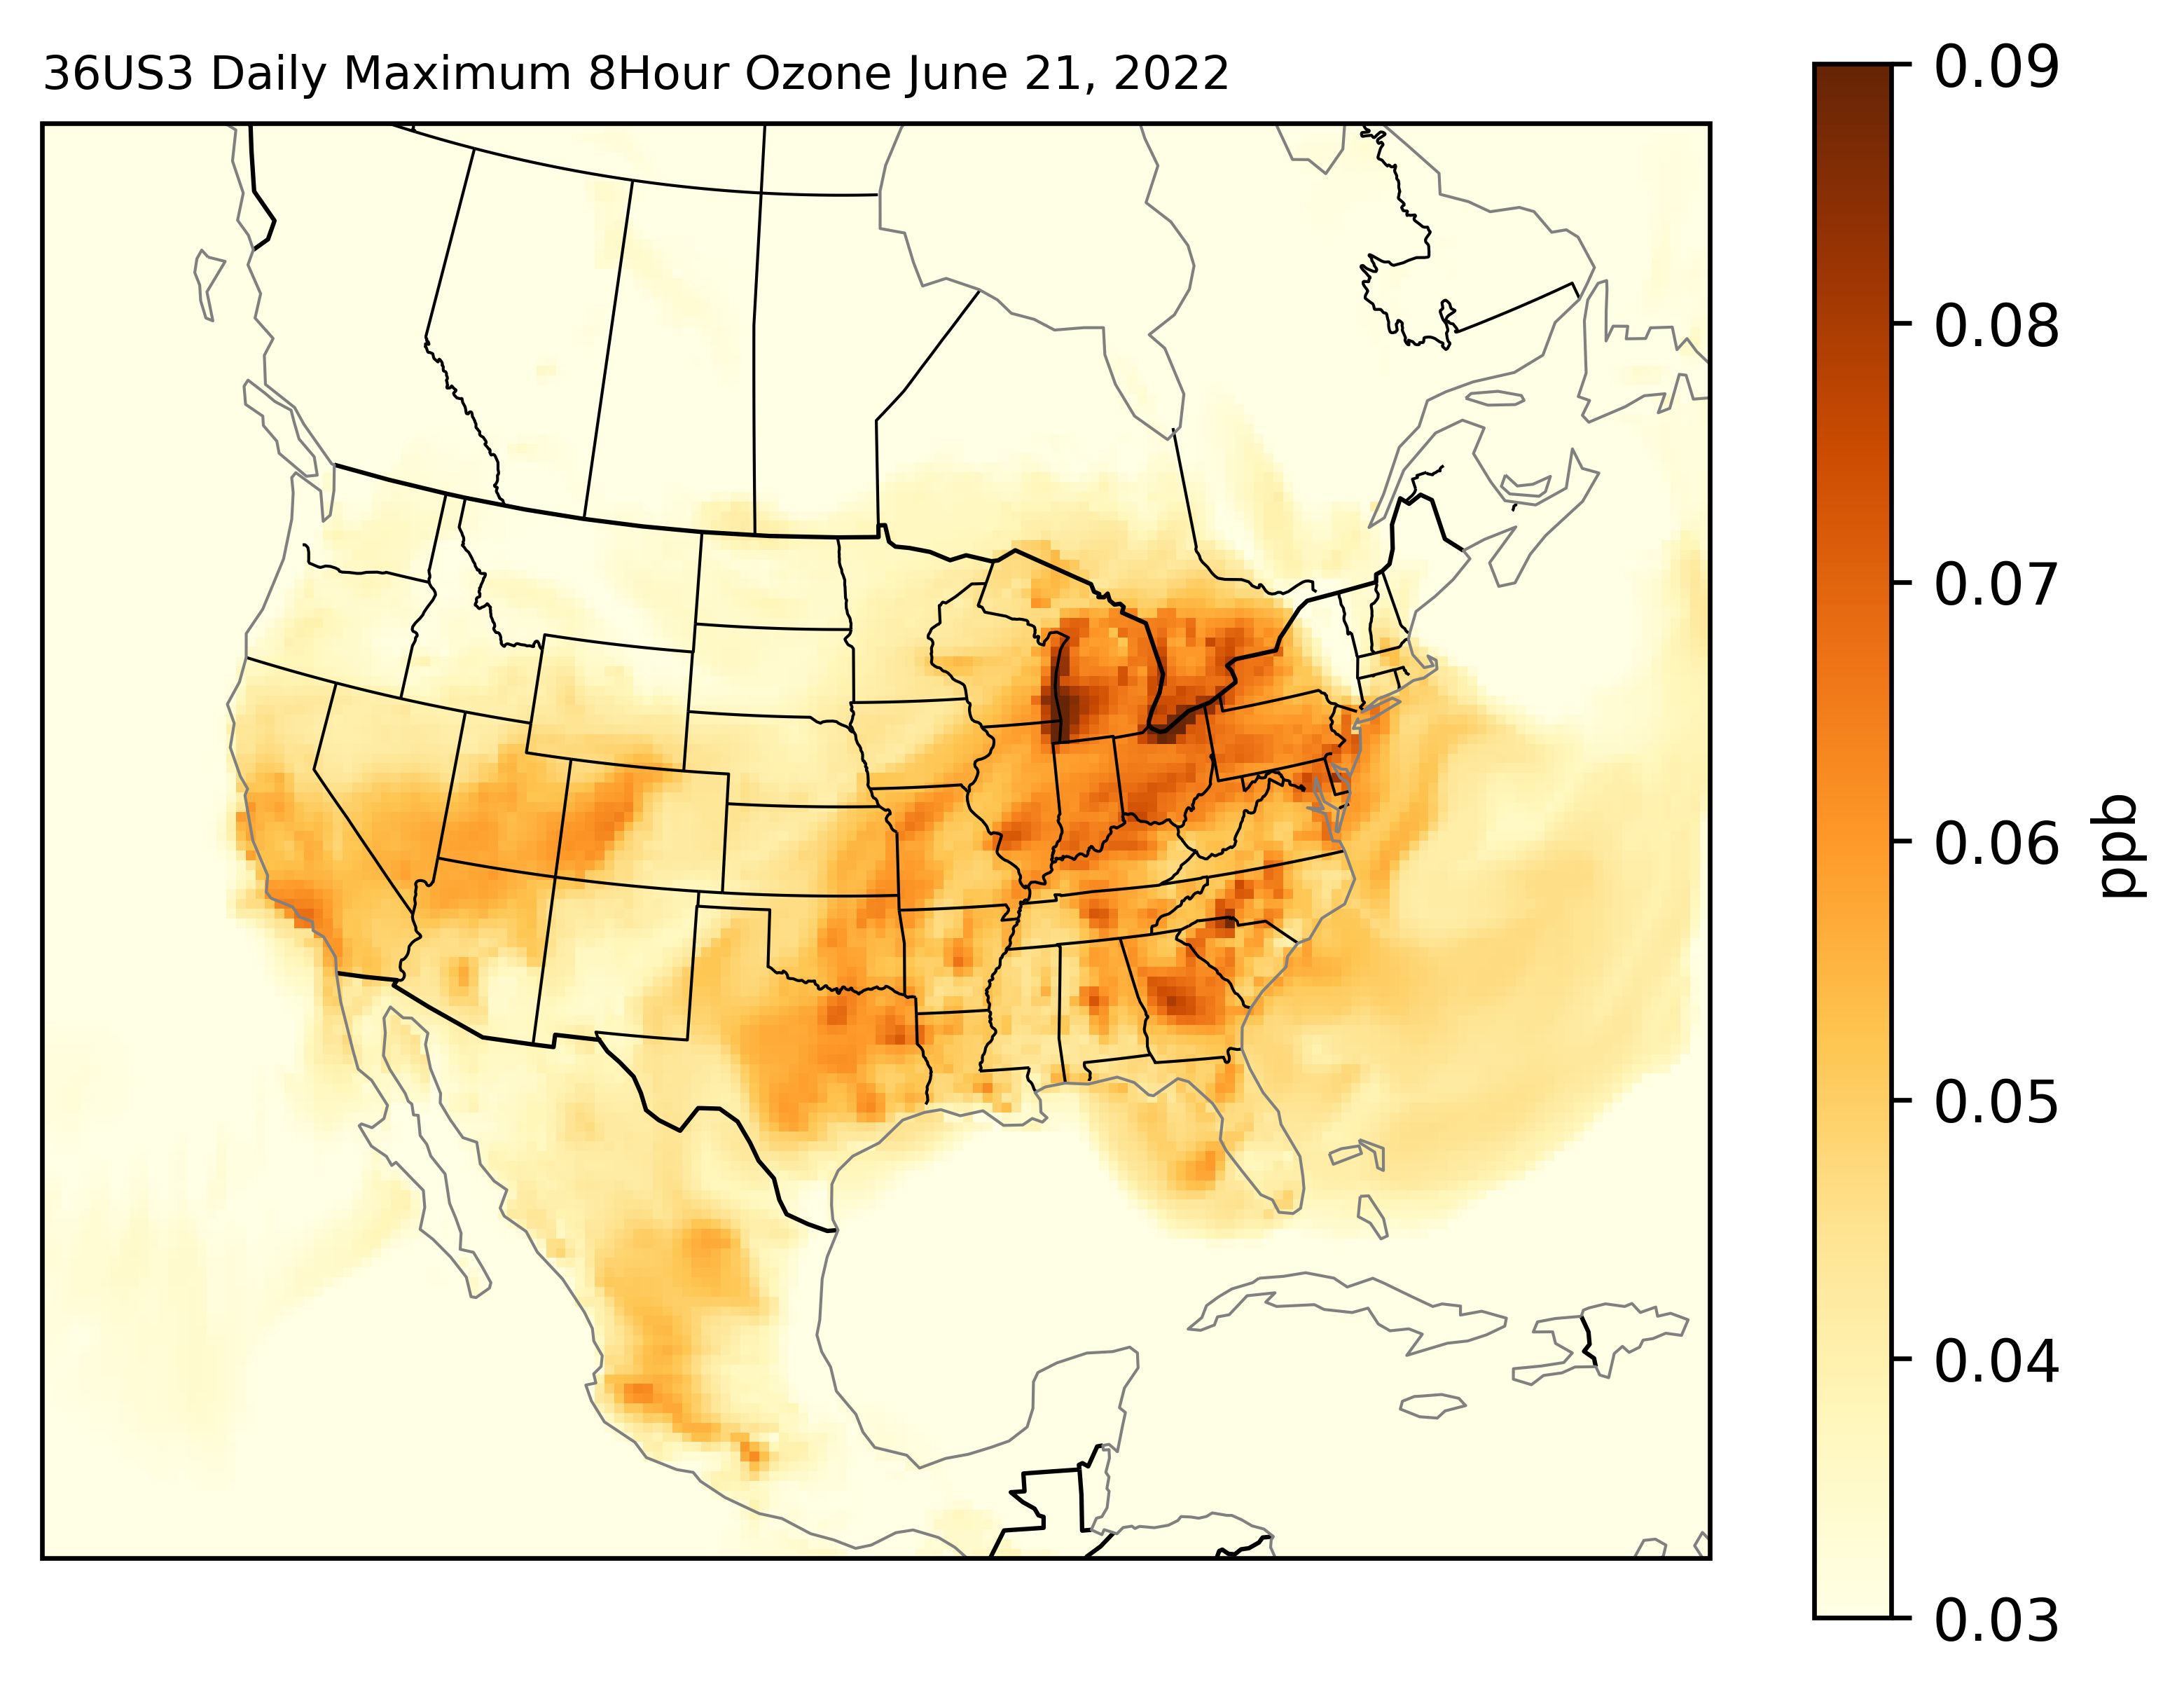

In [13]:
fig, ax = plt.subplots(dpi=600, subplot_kw={"projection": proj})

cs = ax.pcolormesh(
    dset.x,
    dset.y,
    dset["O3"].sel(time=sample_date),
    cmap="YlOrBr",
    vmin=0.03,
    vmax=0.09,
)
cbar = plt.colorbar(cs, ax=ax)

ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="-")
ax.coastlines(color="grey", lw=0.5)


cbar.set_label("ppb")

ax.set_title(
    f"36US3 Daily Maximum 8Hour Ozone {sample_date.strftime("%B %-d, %Y")}",
    loc="left",
    fontsize=8,
)

Text(0.0, 1.0, '36US3 Daily Maximum 8Hour Ozone Exceedances June 21, 2022')

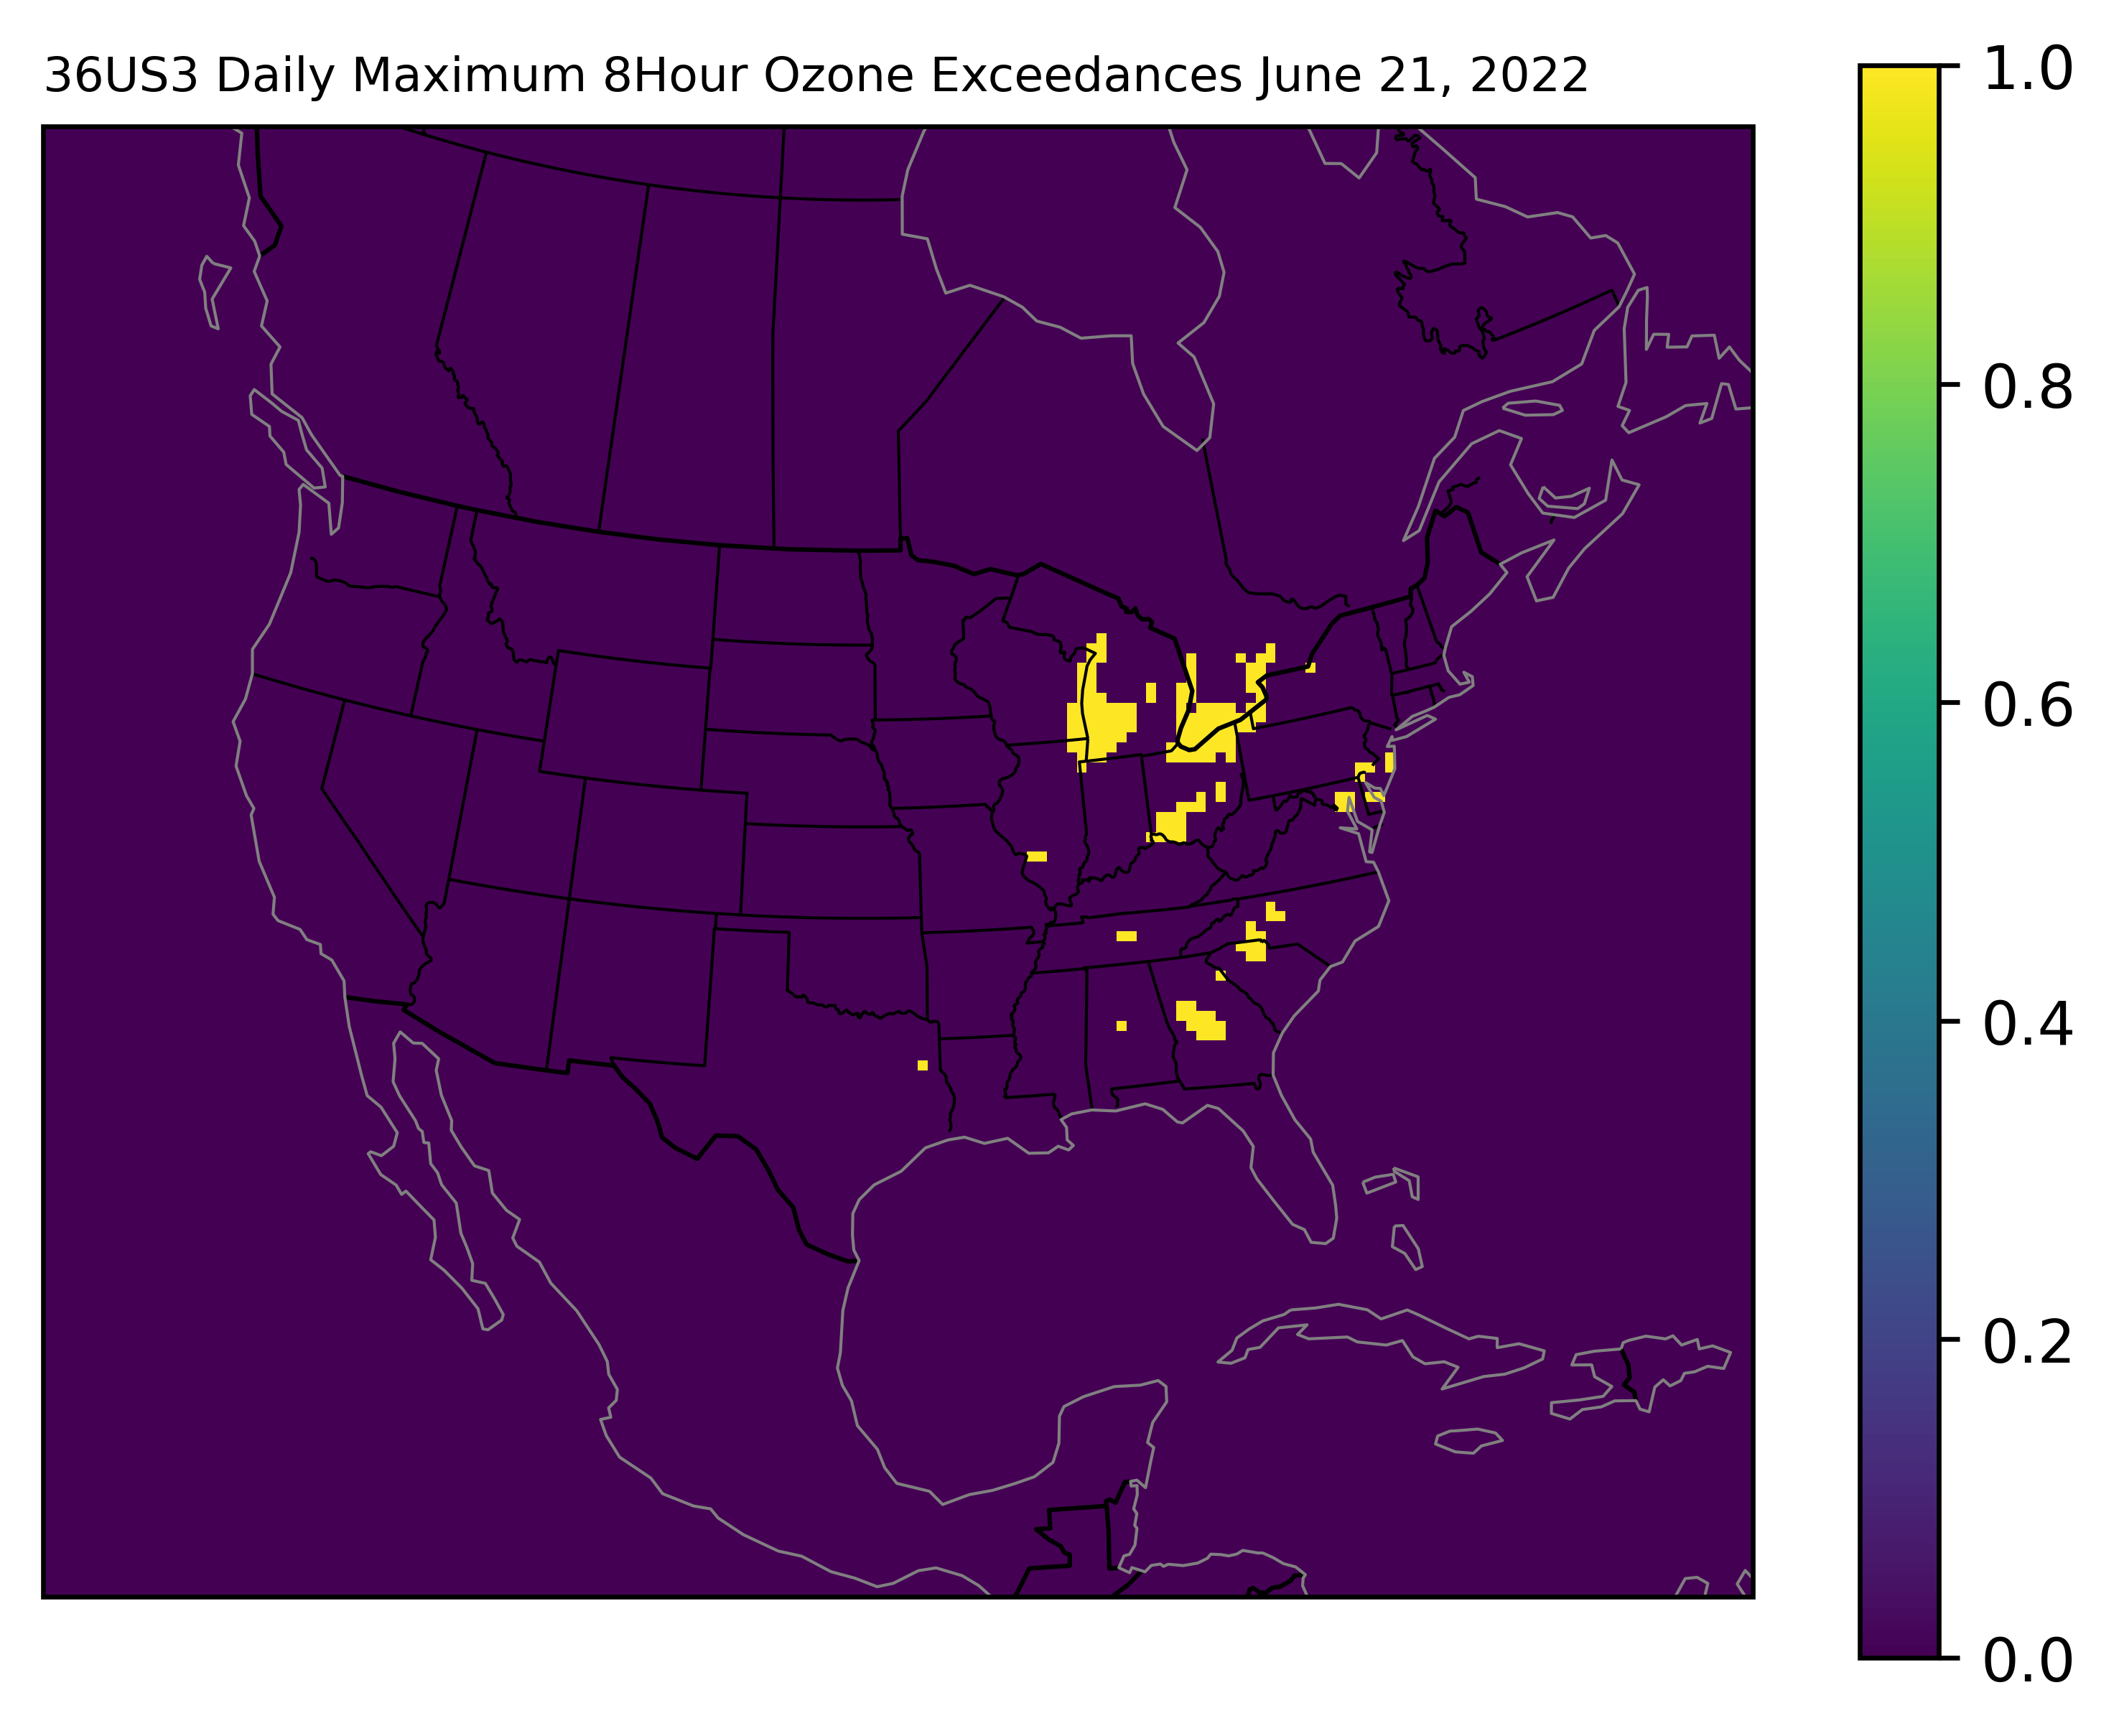

In [14]:
fig, ax = plt.subplots(dpi=600, subplot_kw={"projection": proj})

# Generate a boolean map of whether a grid cell is or is not above 0.070
excd = dset["O3"].sel(time=sample_date)
excd = excd > 0.070

cs = ax.pcolormesh(dset.x, dset.y, excd)
cbar = plt.colorbar(cs, ax=ax)
cbar.set_label("")

ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="-")
ax.coastlines(color="grey", lw=0.5)

ax.set_title(
    f"36US3 Daily Maximum 8Hour Ozone Exceedances {sample_date.strftime("%B %-d, %Y")}",
    loc="left",
    fontsize=8,
)

#### 3.A.1 Generate a custom colormap

A shortcoming of the first map is that smooth gradient reduces the ability to pick out important discrete values. The second map shows the location of exceedances... but it is quite harsh. So for the next image, the important information we would like to highlight includes:
* Spatial structure of high and low ozone concentrations
* Whether or not concentrations at a particular gridcell are above or below the 0.070 threshold


To accomplish these two objectives, we can make a custom colorbar to highlight when the daily averaged ozone exceeds the threshold of 0.070 ppb. We will create this colorbar by combining two [sequential colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) provided natively by MatPlotLib

In [15]:
from matplotlib.colors import ListedColormap

# Setup the range for the desired colorbar
vmin = 0.030
vmax = 0.090
dlev = 0.005
levels = np.arange(vmin, vmax + dlev / 2, dlev)


# Resample the colorbars so that cmap1 has twice as many colors as cmap2. This
# fraction will make it easy to align the limits so that the break between the
# two colorbars occurs right at the deisred 0.070 ppb threshold
cmap1 = mpl.colormaps["PuBuGn"].resampled(256)
cmap2 = mpl.colormaps["OrRd"].resampled(128)

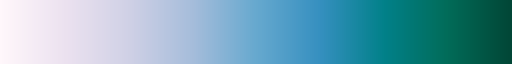

In [16]:
cmap1

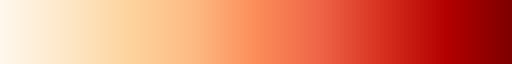

In [17]:
cmap2

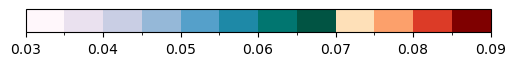

In [18]:
# Generate a list of colors from the two existing cmaps in the desired order,
# from which we will generate the new colormap
clist = []
for n in range(cmap1.N):
    rgb = cmap1(n)
    clist.append(rgb)

for n in range(cmap2.N):
    rgb = cmap2(n)
    clist.append(rgb)

# Generate the new colorbar based on the colorbar list
cmap = ListedColormap(clist, name="ozone")
norm = mpl.colors.BoundaryNorm(ncolors=cmap.N, boundaries=levels)
smap = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

cmap.set_under("w")  # <- all values below our vmin will be mapped to white

# These two lines are just included to dispaly the colorbar
fig, ax = plt.subplots(figsize=(6, 0.3))
fig.colorbar(smap, cax=ax, orientation="horizontal")

Text(0.0, 1.0, '36US3 Daily Maximum 8Hour Ozone June 21, 2022')

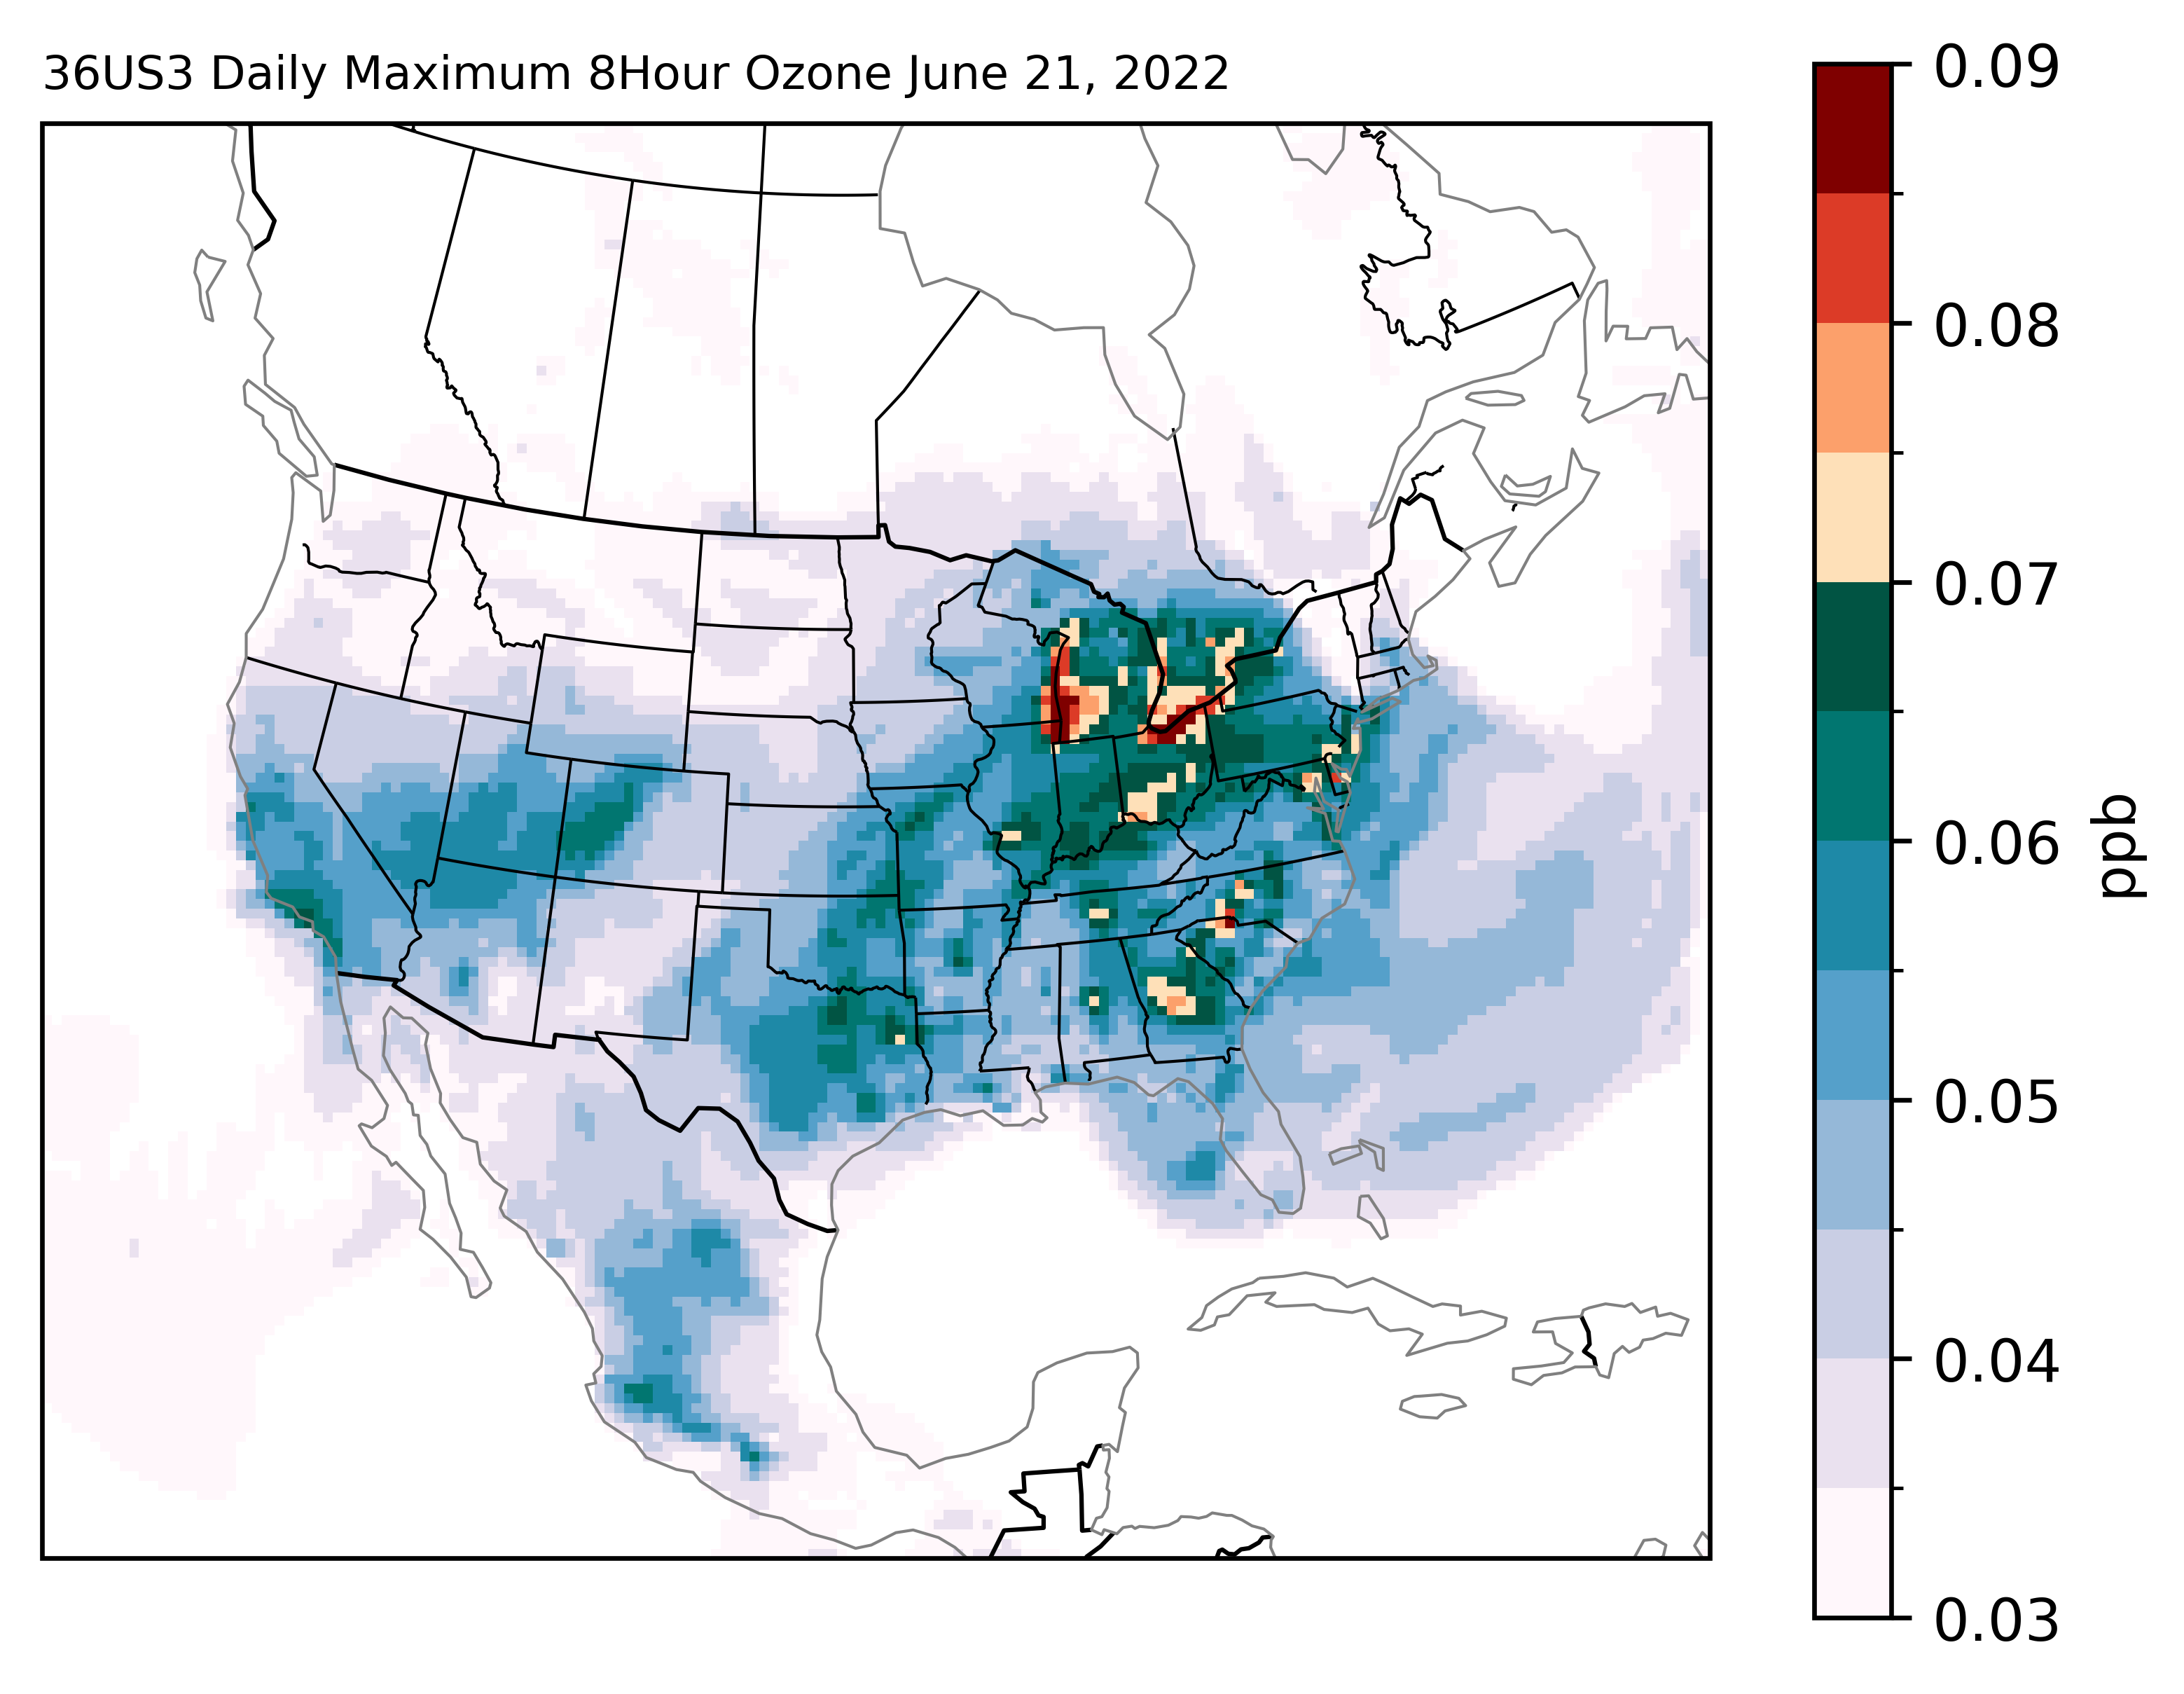

In [19]:
fig, ax = plt.subplots(dpi=600, subplot_kw={"projection": proj})
ax.pcolormesh(dset.x, dset.y, dset["O3"].sel(time=sample_date), cmap=cmap, norm=norm)
cbar = plt.colorbar(smap, ax=ax)

ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="-")
ax.coastlines(color="grey", lw=0.5)


cbar.ax.set_yticks(np.arange(vmin, vmax + dlev / 2, 0.01))
cbar.set_label("ppb")

ax.set_title(
    f"36US3 Daily Maximum 8Hour Ozone {sample_date.strftime("%B %-d, %Y")}",
    loc="left",
    fontsize=8,
)

Here's the same figure as before, but zoomed into a smaller box around St. Louis

Text(0.0, 1.0, 'June 21, 2022')

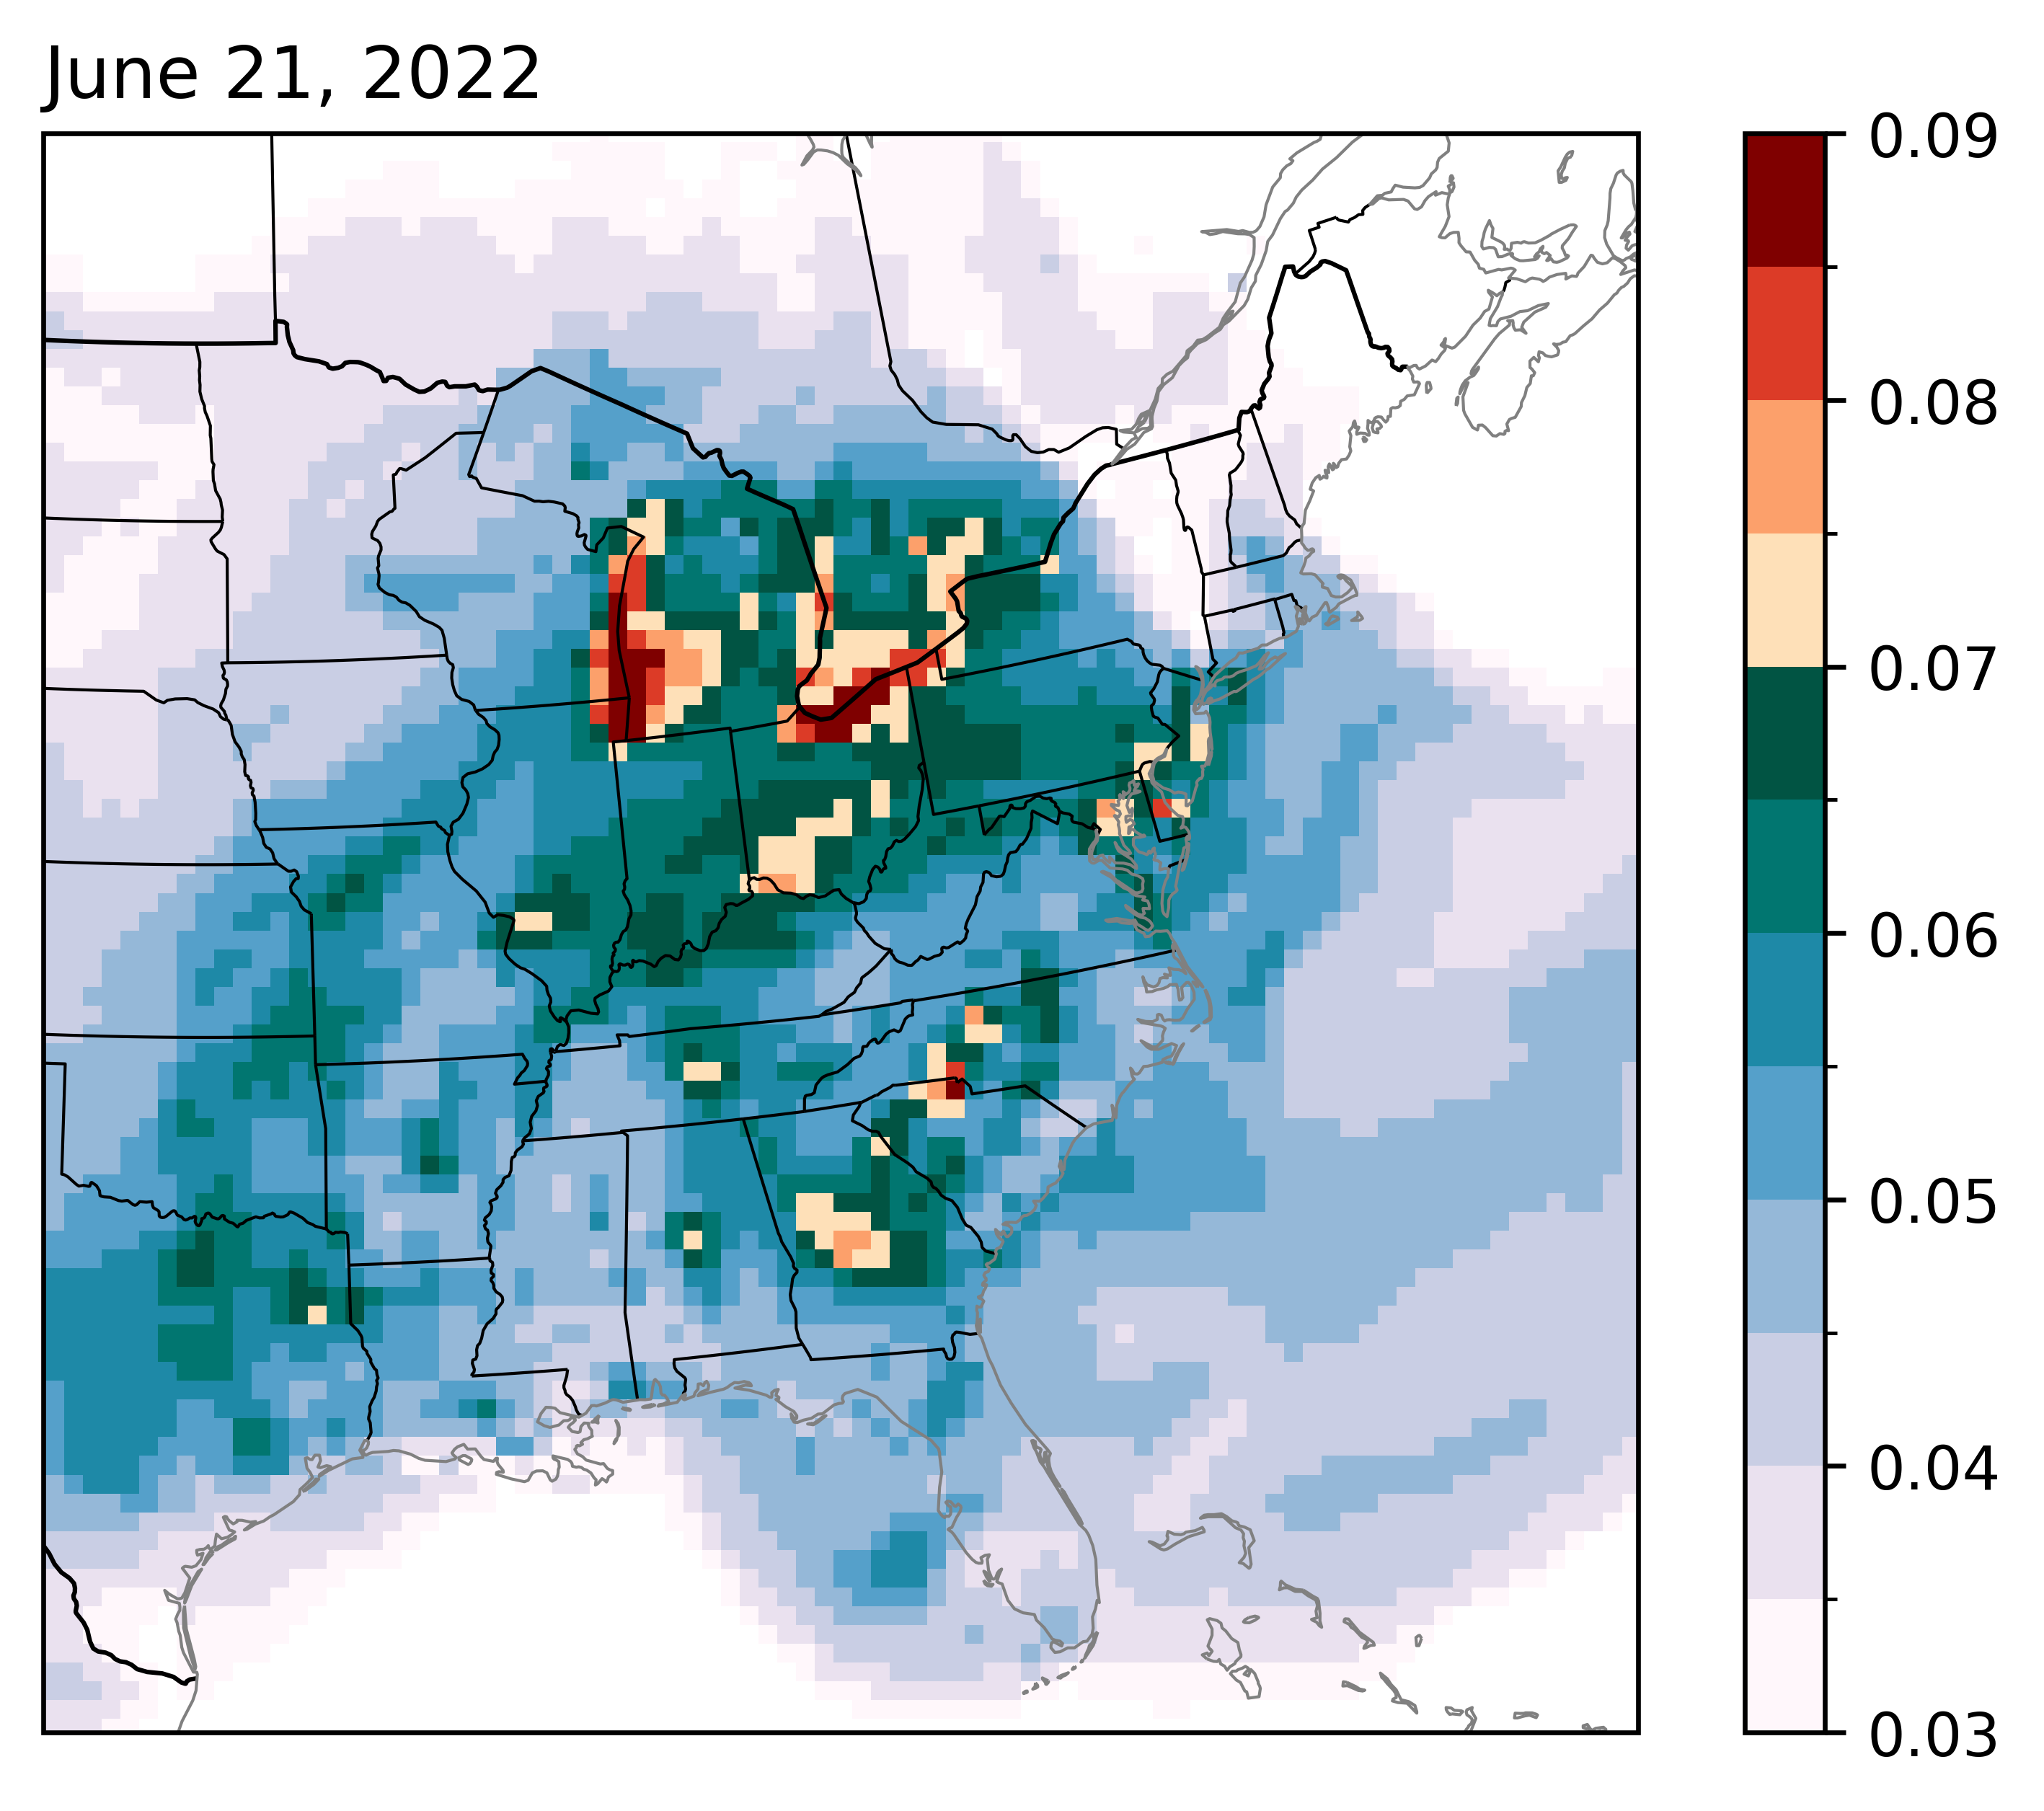

In [20]:
fig, ax = plt.subplots(dpi=600, subplot_kw={"projection": proj})
ax.pcolormesh(dset.x, dset.y, dset["O3"].sel(time=sample_date), cmap=cmap, norm=norm)
cbar = plt.colorbar(smap, ax=ax)

ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="-")
ax.coastlines(color="grey", lw=0.5)

ax.set_extent([-100, -70, 25, 50], crs=ccrs.PlateCarree())
cbar.ax.set_yticks(np.arange(vmin, vmax + dlev / 2, 0.01))

ax.set_title(f"{sample_date.strftime("%B %-d, %Y")}", loc="left")

### 3.B Pandas vs. Xarray Indexing

Lastly, we index the ozone data to find dates in which MDA8O3 is greater than the 0.070 ppb threshold. The data can be kept as an xarray dataarray, or converted to pandas. Both methods give equivalent results with different syntax, and converting between the two methods is straightforward


In [21]:
thr = 0.070

# The dates of exceedances can be found using xarray --------------------------

o3 = dset_stl["O3"]
o3_excd = o3.isel(time=o3 > thr)

print("WITH XARRAY:")
print(o3_excd)
print("-" * 79)

# But I prefer use pandas syntax ----------------------------------------------

o3 = dset_stl["O3"].to_pandas()
o3_excd = o3[o3 > thr]

print("WITH PANDAS:")
print(o3_excd)

WITH XARRAY:
<xarray.DataArray 'O3' (time: 5)> Size: 20B
array([0.080973, 0.071624, 0.072353, 0.075397, 0.072154], dtype=float32)
Coordinates:
    x        float64 8B 3.528e+06
    y        float64 8B 2.664e+06
  * time     (time) datetime64[ns] 40B 2022-06-20 2022-06-25 ... 2022-07-22
Attributes:
    long_name:  O3              
    units:      ppbV            
    var_desc:   Max-8-hour                                                   ...
-------------------------------------------------------------------------------
WITH PANDAS:
time
2022-06-20    0.080973
2022-06-25    0.071624
2022-06-29    0.072353
2022-06-30    0.075397
2022-07-22    0.072154
dtype: float32


In [22]:
# Find the date with the greatest number of exceedances across the domain to
# demonstrate the colorbar

excd_per_day = (dset["O3"] > 0.070).sum(dim=("y", "x")).to_pandas()

sample_date = excd_per_day.sort_values(ascending=False).index[0]

#### 3.B.1 Make a map for each of the exceedance days

Text(0.5, 0.98, '36US3 Modeled Ozone Exceedances in St. Louis')

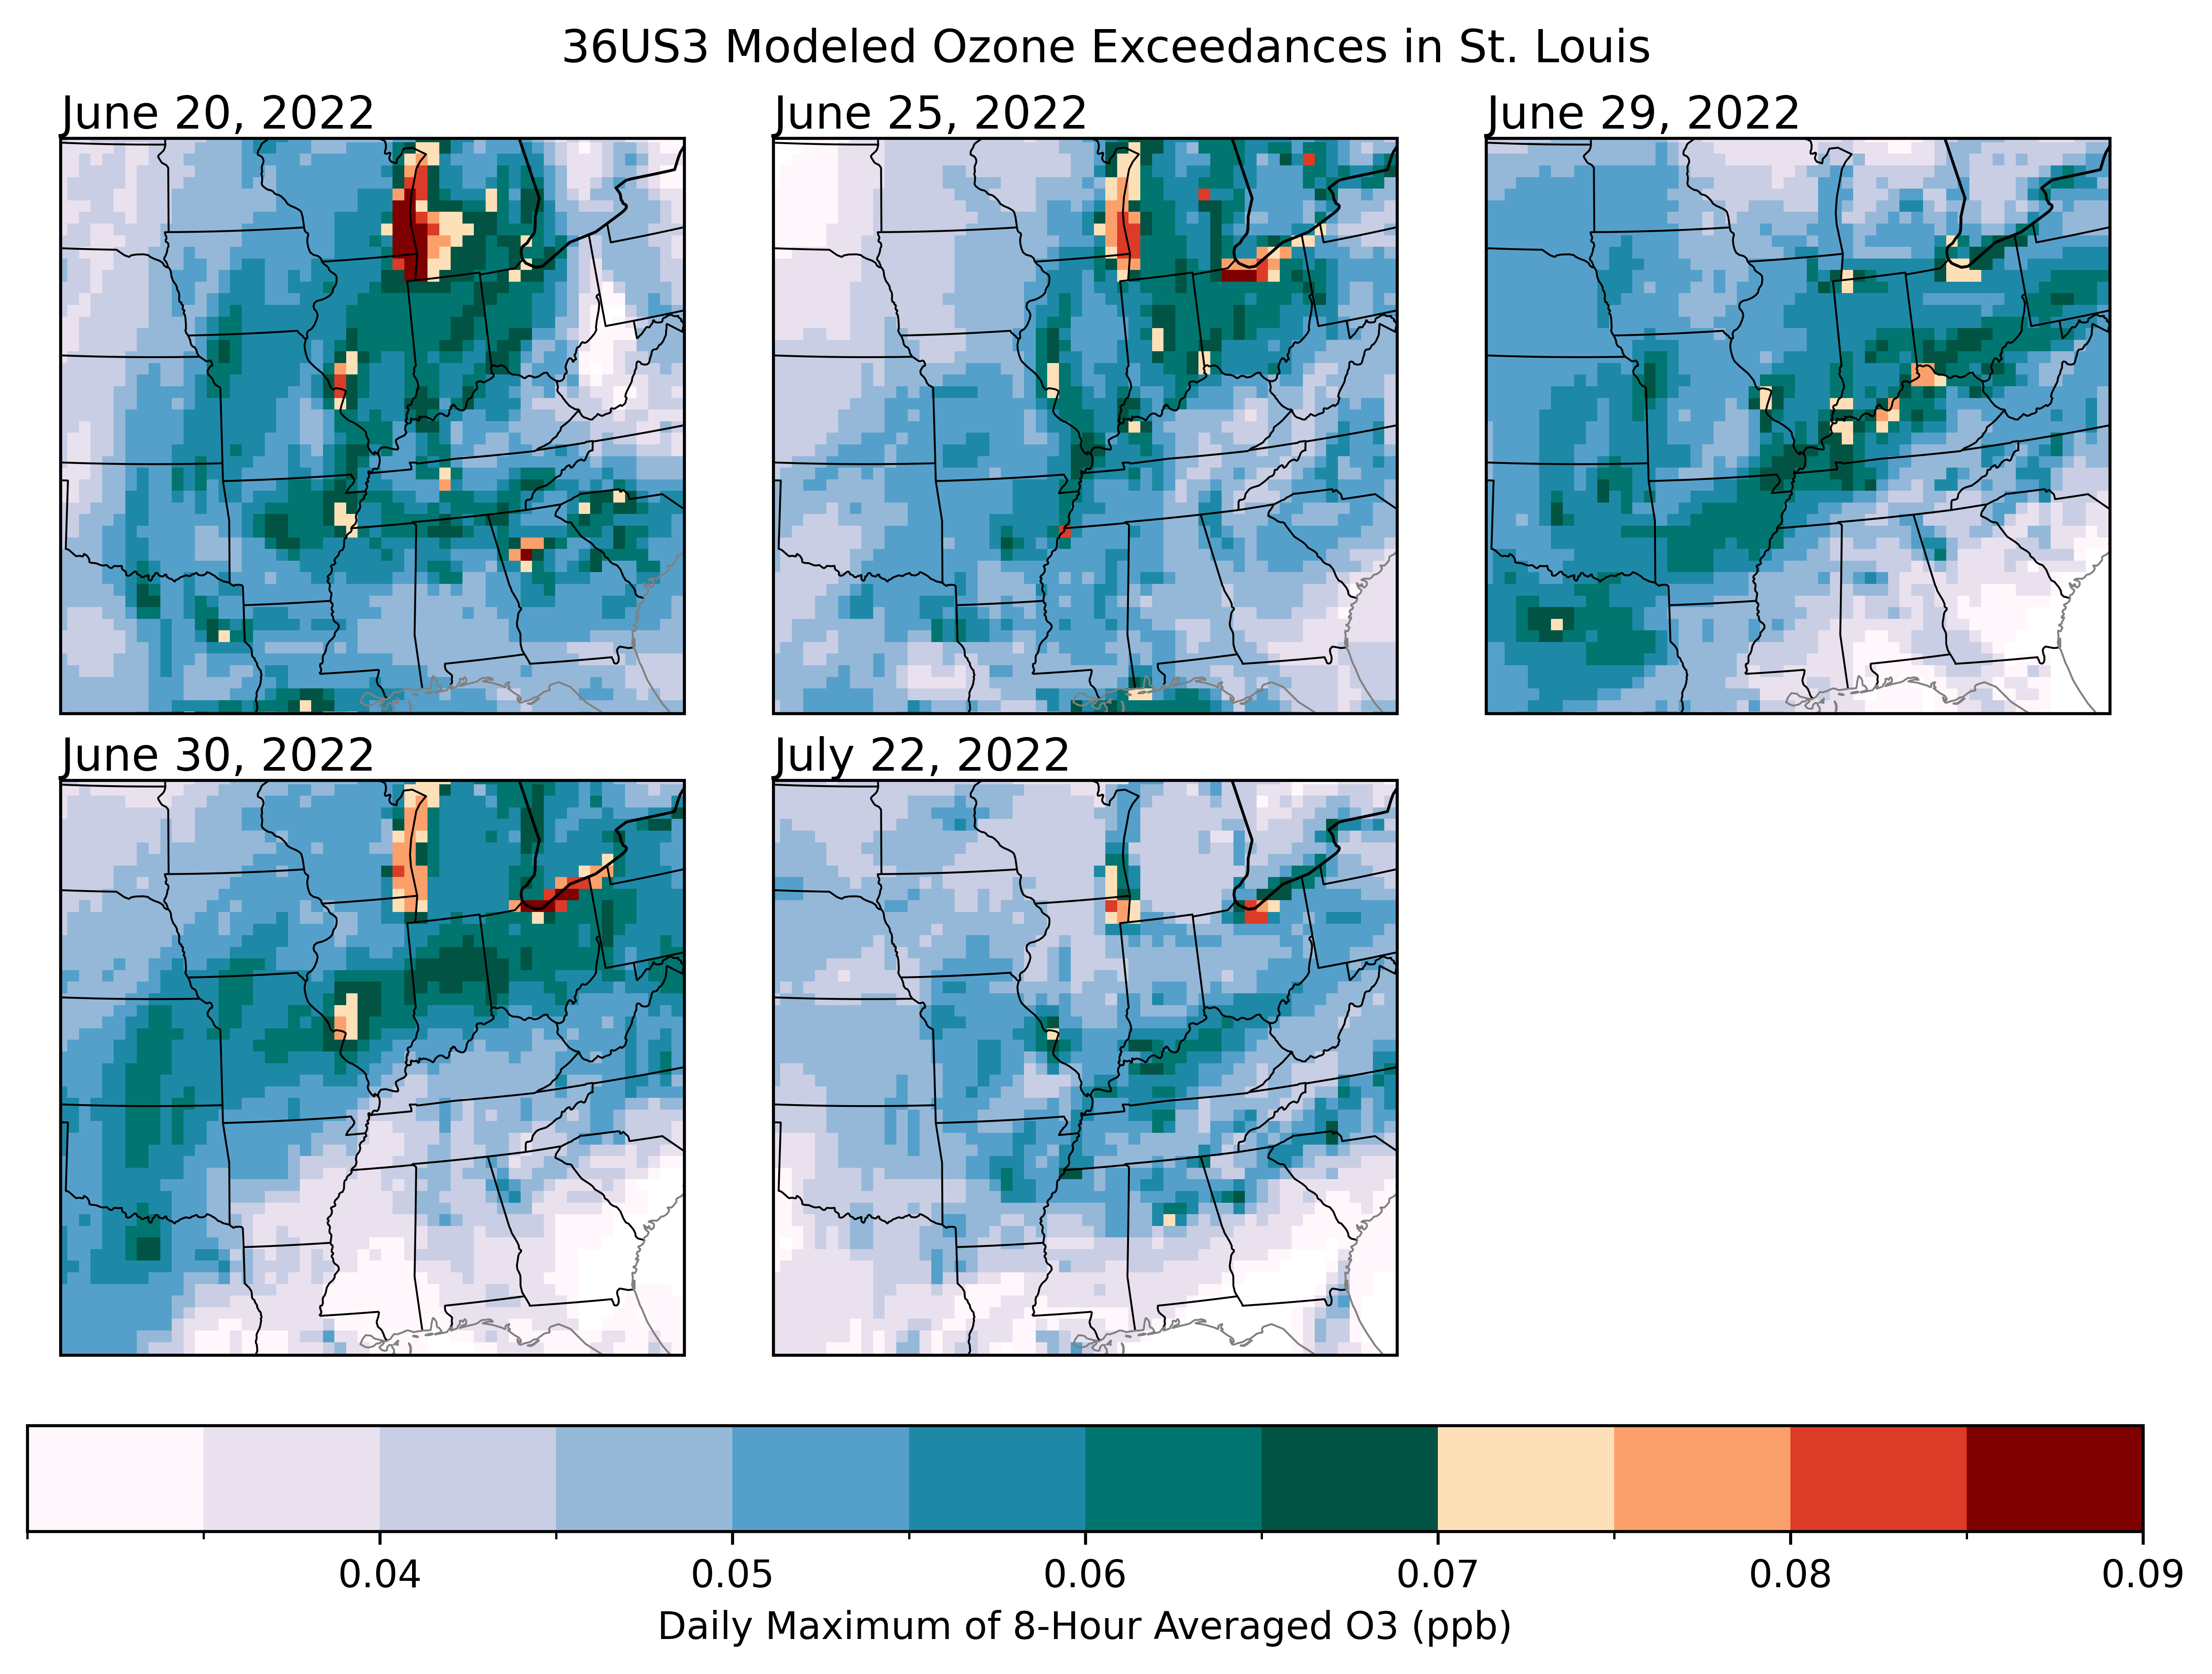

In [23]:
fig, axs = plt.subplots(
    figsize=(8, 6),
    nrows=2,
    ncols=3,
    subplot_kw={"projection": proj},
    dpi=600,
    layout="constrained",
)

axs = axs.flatten()  # <- plt.subplots returns a nrowsXncols array, so flatten
#    to a 1D array for streamlined looping

# Iterate over dates and subplot axes
for date, ax in zip(o3_excd.index, axs):

    # Index the data based on the current date
    plot_data = dset["O3"].sel(time=date)

    ax.pcolormesh(
        plot_data.x, plot_data.y, plot_data, transform=proj, cmap=cmap, norm=norm
    )

    # Add additional details to the plots
    ax.set_title(date.strftime("%-B %-d, %Y"), loc="left", va="top")
    ax.add_feature(cfeature.BORDERS, ec="k", fc="none", lw=0.75)
    ax.add_feature(states_provinces, ec="k", fc="none", lw=0.5, ls="-")
    ax.coastlines(color="grey", lw=0.5)

    ax.set_extent([-100, -80, 30, 45], crs=ccrs.PlateCarree())

# Hide the 6th axis because only 5 exceedances were found
axs[-1].axis("off")

# Add and format the colorbar
cbar = fig.colorbar(smap, ax=axs, location="bottom", pad=0.05)
cbar.ax.set_xticks(np.arange(0.04, 0.1, 0.01))
cbar.set_label("Daily Maximum of 8-Hour Averaged O3 (ppb)")

fig.suptitle("36US3 Modeled Ozone Exceedances in St. Louis")